<a href="https://colab.research.google.com/github/hasdasda/HoctheoPhamDinhKhanh/blob/main/ANM_CK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
%cd VNPT
%cd VNPT_01

/content/drive/.shortcut-targets-by-id/1UnC-iLs86hXm-MhLt4GMg_ua_MKNBL4I/VNPT
/content/drive/.shortcut-targets-by-id/1UnC-iLs86hXm-MhLt4GMg_ua_MKNBL4I/VNPT/VNPT_01


In [ ]:
!ls

Dap_an_and_pca.ipynb  De_bai.ipynb  IoTID20.csv  Model.ipynb  UNSW_2018_IoT_Botnet_Dataset_1.csv


In [ ]:
#Bước 1: Import thư viện
import pandas as pd
import numpy as np
from math import floor
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Các thư viện cần thiết để train model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D

import sys
from os import mkdir
from os.path import exists as path_exists
from os.path import join
import time

import keras
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from tqdm import tqdm

In [ ]:
#Bước 2: Đọc file đầu vào
#Nếu file input là file excel thì thay read_csv bằng read_excel
#header chỉ dòng chứa tên các features, index_col chỉ cột chứa số thứ tự các mẫu đầu vào
#Nếu có header/index đặtt giá trị biến = 0, nếu không đặt = None
data = pd.read_csv('IoTID20.csv', header=0, index_col=None)

In [ ]:
# Thay thế các giá trị infinity bằng các giá trị na
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna() # Loại bỏ các giá trị na

In [ ]:
data

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


In [ ]:
#Khởi tạo biến thư viện
encoder = LabelEncoder()
#Cho thuật toán đọc các nhãn các loại tấn công
#Ở đây ta chỉ làm bài toán phân loại 2 lớp: Anomaly và Normal
encoder.fit(data.iloc[:,-3])
encoder.classes_
#Nếu tại đây ta sử dụng câu lệnh transform thì nhãn DoS sẽ có label 0, MITM label1,
#Mirai-Ackflooding label 2, ... Normal label 6
#Để Normal có nhãn 0 ta sắp xếp lại thứ tự các class
#Normal label 0, DoS label 1, Mirai label 2-5, MITM label 6, Scan label 7-8
#encoder.classes_ = np.array(['Normal', 'DoS-Synflooding', 'Mirai-Ackflooding',
#         'Mirai-HTTP Flooding', 'Mirai-Hostbruteforceg', 'Mirai-UDP Flooding',
#         'MITM ARP Spoofing', 'Scan Hostport', 'Scan Port OS'])
#Label chuyển từ dạng chữ sang dạng số
y = encoder.transform(data.iloc[:,-3])

In [ ]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
#Loại bỏ ip, timestamp, ID ra khỏi data X
X = pd.concat([data.iloc[:,2], data.iloc[:,4:6], data.iloc[:,7:-3]], axis = 1)

In [ ]:
#Bước 3: Cắt lấy file train và file test
#Trong VD này, ta lấy 1/3 số mẫu của tất cả các label
#Khi cắt cần đảm bảo số mẫu của từng label không quá chênh lệch, quá nhỏ
#Cắt data ra làm 2 phần, train chiếm 70%, test chiếm 30% => Train_size = 1/3*0.7=7/30, test_size = 1/3*0.3=0.1
from sklearn.model_selection import train_test_split
#X_train và X_test là các features, y_train và y_test lần lượt là nhãn bộ train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=7/30, test_size=0.1,shuffle=True)


In [ ]:
#Bước 4: Chuẩn hóa dữ liệu
#X = (x-xmin)/(xmax-xmin)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
#Với bộ dữ liệu VD, 2 cột đầu tiên của data là port number, có giá trị từ 0-65535.
scaler.data_max_[0:2] = np.array([65535, 65535])
scaler.data_min_[0:2] = np.array([0, 0])

#Chuẩn hóa dữ liệu
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


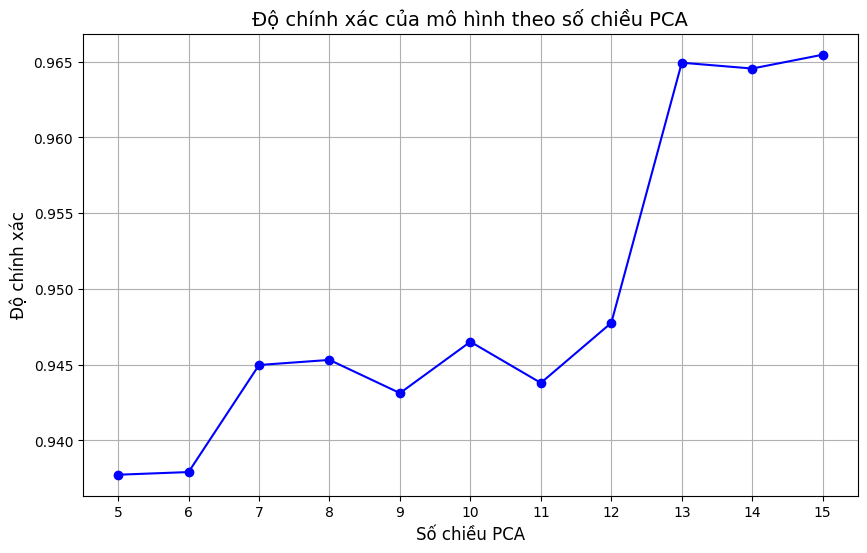

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Giả sử X_train_norm, X_test_norm, y_train, y_test đã được định nghĩa

# Hàm tạo mô hình mạng nơ-ron
def simpleANN(input_shape):
    model = Sequential()
    model.add(Dense(1, kernel_initializer='random_normal', input_dim=input_shape))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    return model

# Khởi tạo danh sách để lưu kết quả
dimensions = range(5, 16)  # Số chiều từ 5 đến 15
accuracies = []

for dim in dimensions:
    # Áp dụng PCA
    pca = PCA(n_components=dim)
    X_train_pca = pca.fit_transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)

    # Tạo và biên dịch mô hình
    model = simpleANN(input_shape=dim)
    adamopt = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adamopt, metrics=['accuracy'])

    # Huấn luyện mô hình với Early Stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_train_pca, y_train, epochs=50, batch_size=512, callbacks=[callback], verbose=0)

    # Dự đoán và tính độ chính xác
    y_pred_prob = model.predict(X_test_pca)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Chuyển đổi xác suất thành nhãn dự đoán
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(dimensions, accuracies, marker='o', linestyle='-', color='b')
plt.title('Độ chính xác của mô hình theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.xticks(dimensions)
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


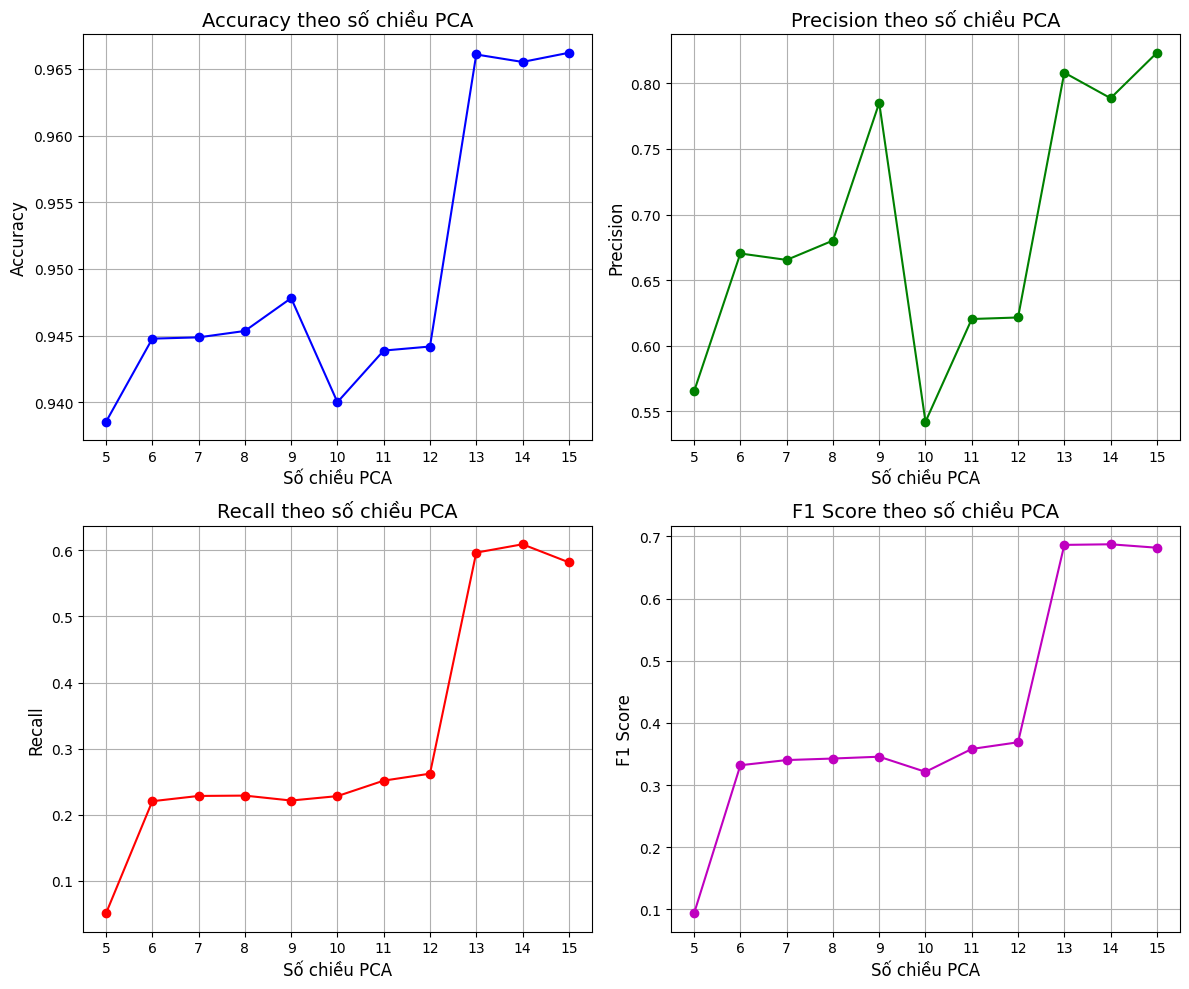

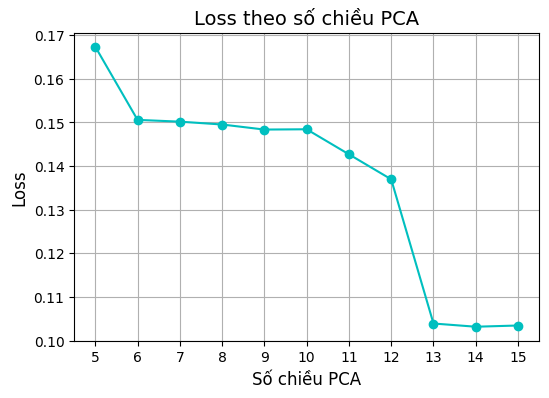

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Giả sử X_train_norm, X_test_norm, y_train, y_test đã được định nghĩa

# Hàm tạo mô hình mạng nơ-ron
def simpleANN(input_shape):
    model = Sequential()
    model.add(Dense(1, kernel_initializer='random_normal', input_dim=input_shape))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    return model

# Khởi tạo danh sách để lưu kết quả
dimensions = range(5, 16)  # Số chiều từ 5 đến 15
accuracies = []
precisions = []
recalls = []
f1_scores = []
losses = []

for dim in dimensions:
    # Áp dụng PCA
    pca = PCA(n_components=dim)
    X_train_pca = pca.fit_transform(X_train_norm)
    X_test_pca = pca.transform(X_test_norm)

    # Tạo và biên dịch mô hình
    model = simpleANN(input_shape=dim)
    adamopt = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adamopt, metrics=['accuracy'])

    # Huấn luyện mô hình với Early Stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train_pca, y_train, epochs=50, batch_size=512, callbacks=[callback], verbose=0)

    # Dự đoán và tính các chỉ số
    y_pred_prob = model.predict(X_test_pca)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Chuyển đổi xác suất thành nhãn dự đoán

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = history.history['loss'][-1]  # Lấy giá trị loss cuối cùng

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss)

# Vẽ biểu đồ
plt.figure(figsize=(12, 10))

# Biểu đồ Accuracy
plt.subplot(2, 2, 1)
plt.plot(dimensions, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(dimensions)
plt.grid()

# Biểu đồ Precision
plt.subplot(2, 2, 2)
plt.plot(dimensions, precisions, marker='o', linestyle='-', color='g')
plt.title('Precision theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.xticks(dimensions)
plt.grid()

# Biểu đồ Recall
plt.subplot(2, 2, 3)
plt.plot(dimensions, recalls, marker='o', linestyle='-', color='r')
plt.title('Recall theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xticks(dimensions)
plt.grid()

# Biểu đồ F1 Score
plt.subplot(2, 2, 4)
plt.plot(dimensions, f1_scores, marker='o', linestyle='-', color='m')
plt.title('F1 Score theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(dimensions)
plt.grid()

plt.tight_layout()
plt.show()

# Biểu đồ Loss
plt.figure(figsize=(6, 4))
plt.plot(dimensions, losses, marker='o', linestyle='-', color='c')
plt.title('Loss theo số chiều PCA', fontsize=14)
plt.xlabel('Số chiều PCA', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(dimensions)
plt.grid()
plt.show()

Số lượng thành phần chính cần thiết để giữ lại 95% phương sai: 7


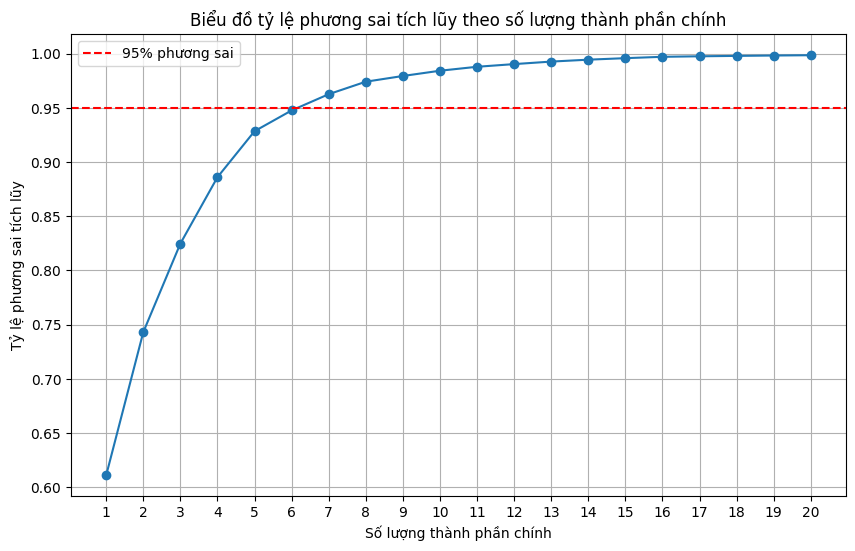

In [ ]:
# Áp dụng PCA
pca = PCA()
pca.fit(X_train_norm)

# Tính tỷ lệ phương sai tích lũy
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Xác định số lượng thành phần cần thiết để giữ lại 95% phương sai
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f'Số lượng thành phần chính cần thiết để giữ lại 95% phương sai: {n_components_95}')

# Giới hạn số lượng thành phần hiển thị trên biểu đồ
max_components = 20
components = np.arange(1, max_components + 1)
cumulative_variance_ratio_limited = cumulative_variance_ratio[:max_components]

# Vẽ biểu đồ tỷ lệ phương sai tích lũy
plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_variance_ratio_limited, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% phương sai')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Biểu đồ tỷ lệ phương sai tích lũy theo số lượng thành phần chính')
plt.xticks(components)
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
    hidden_layers  neurons_per_layer  accuracy  precision    recall  f1_score  \
0               1                 10  0.955758   0.703050  0.543155  0.612845   
1               1                 20  0.968981   0.766837  0.745536  0.756036   
2               1                 50  0.976576   0.827674  0.804067  0.815700   
3               1                100  0.967750   0.915464  0.550595  0.687626   
4               2                 10  0.944038   0.661408  0.270337  0.383803   
5               2                 20  0.961610   0.913749  0.446677  0.600033   
6               2                 50  0.952176   0.744711  0.392857  0.514369   
7               2                100  0.973586   0.979839  0.602679  0.746314   
8               3                 10  0.951792   0.814083  0.326885  0.466466   
9               3                 20  0.975888   0.842377  0.770089  0.804613   
10              3                 50  0.978127   0.835685  0.82242

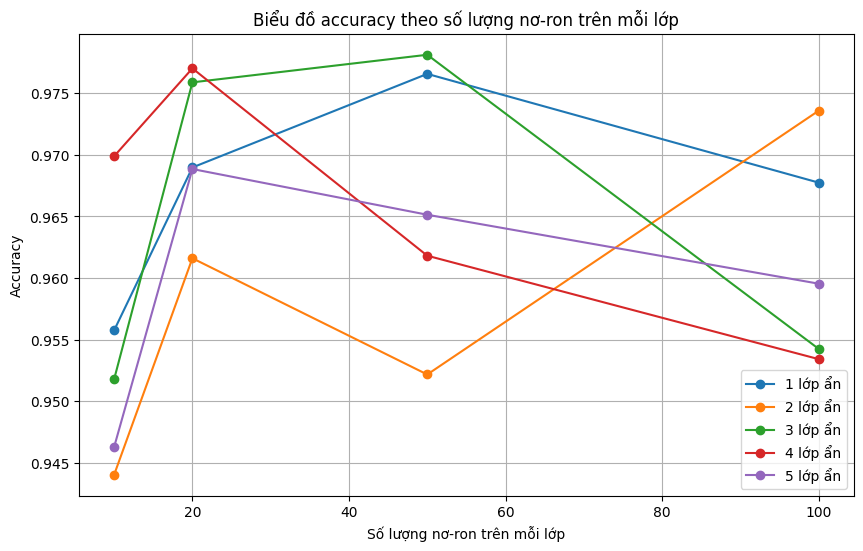

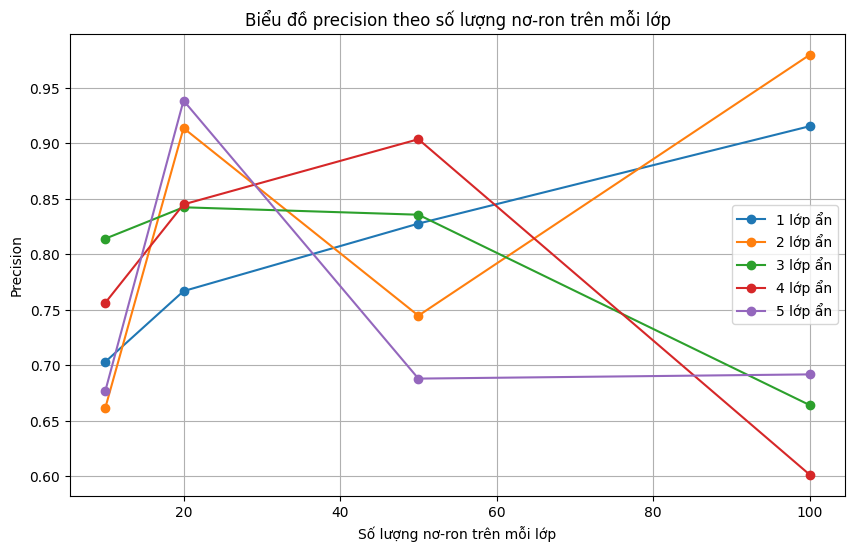

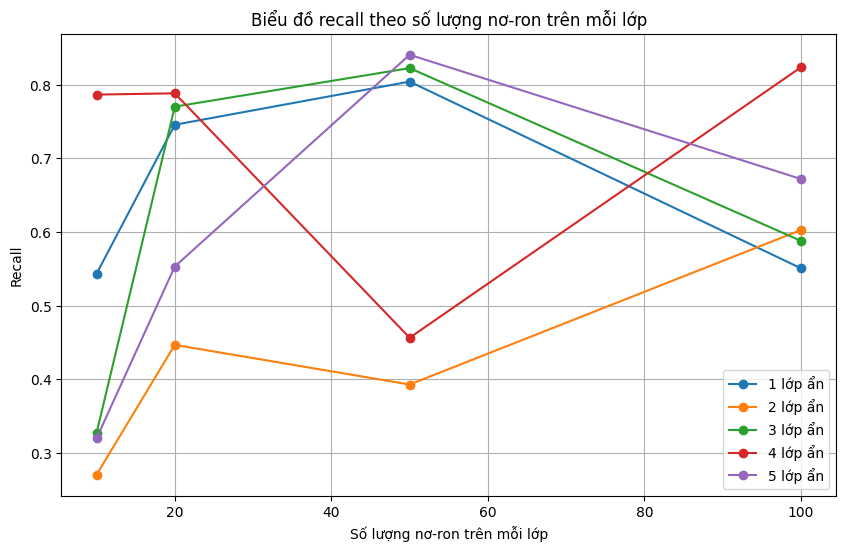

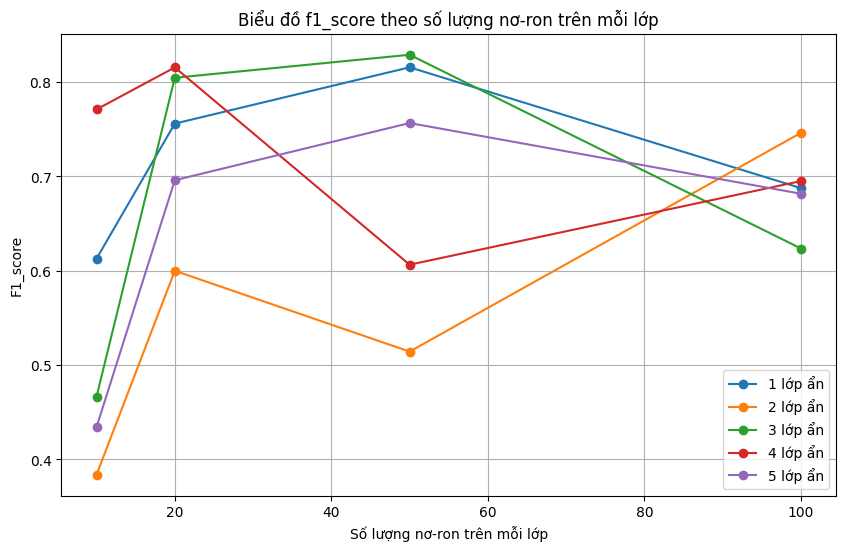

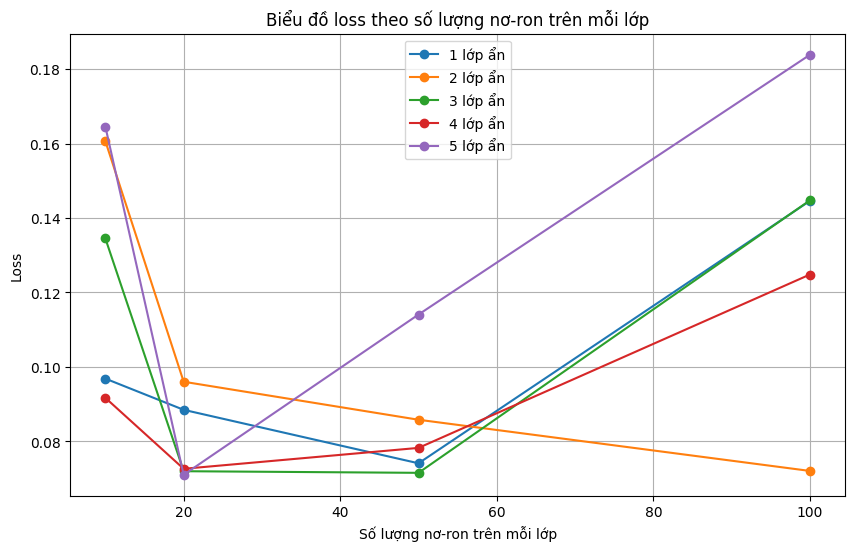

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

# Giả sử X_train_norm, X_test_norm, y_train, y_test đã được định nghĩa và chuẩn hóa

# Áp dụng PCA để giảm số chiều xuống còn 7
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

# Hàm tạo mô hình mạng nơ-ron với số lượng lớp ẩn và nơ-ron tùy chỉnh
def create_model(input_shape, hidden_layers, neurons_per_layer):
    model = Sequential()
    model.add(Dense(neurons_per_layer[0], activation='relu', input_dim=input_shape))
    model.add(BatchNormalization())
    for i in range(1, hidden_layers):
        model.add(Dense(neurons_per_layer[i], activation='relu'))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Các cấu hình cần thử nghiệm
hidden_layer_configs = [1, 2, 3, 4, 5]  # Số lượng lớp ẩn
neurons_per_layer_configs = [10, 20, 50, 100]  # Số lượng nơ-ron trong mỗi lớp

# Lưu trữ kết quả
results = []

# Huấn luyện và đánh giá mô hình với từng cấu hình
for hidden_layers in hidden_layer_configs:
    for neurons_per_layer in neurons_per_layer_configs:
        # Tạo danh sách số nơ-ron cho mỗi lớp ẩn
        neurons = [neurons_per_layer] * hidden_layers

        # Tạo và biên dịch mô hình
        model = create_model(input_shape=7, hidden_layers=hidden_layers, neurons_per_layer=neurons)
        sgd = SGD(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

        # Huấn luyện mô hình
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        model.fit(X_train_pca, y_train, epochs=100, batch_size=128, callbacks=[callback], verbose=0)

        # Dự đoán trên tập kiểm tra
        y_pred_prob = model.predict(X_test_pca)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Tính các chỉ số đánh giá
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        loss = log_loss(y_test, y_pred_prob)

        # Lưu kết quả
        results.append({
            'hidden_layers': hidden_layers,
            'neurons_per_layer': neurons_per_layer,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'loss': loss
        })

# Chuyển kết quả thành DataFrame để dễ dàng hiển thị
import pandas as pd
results_df = pd.DataFrame(results)

# Hiển thị kết quả
print(results_df)

# Vẽ biểu đồ cho từng chỉ số đánh giá
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for hidden_layers in hidden_layer_configs:
        subset = results_df[results_df['hidden_layers'] == hidden_layers]
        plt.plot(subset['neurons_per_layer'], subset[metric], marker='o', label=f'{hidden_layers} lớp ẩn')
    plt.title(f'Biểu đồ {metric} theo số lượng nơ-ron trên mỗi lớp')
    plt.xlabel('Số lượng nơ-ron trên mỗi lớp')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

